In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/data/Train.xlsx', sheet_name = 'Monthly')
df = df.drop(labels = [0],axis = 0)
df = df.fillna(0)
df.rename(columns = {'Unnamed: 0' : 'time'}, inplace = True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 100

Прогнозирование на основе одномерного временного ряда

In [ ]:
tf.random.set_seed(13)

In [ ]:
print(tf.random.uniform([1]))

tf.Tensor([0.41364384], shape=(1,), dtype=float32)


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))
  
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], future])
  plt.xlabel('Time-Step')
  return plt

In [ ]:

def solution(uni_data, layers_num):
  uni_data.index = df['time']
  #uni_data.head()
  #uni_data.plot(subplots=True)
  uni_data = uni_data.values
  uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
  uni_train_std = uni_data[:TRAIN_SPLIT].std()
  uni_data = (uni_data-uni_train_mean)/uni_train_std
  univariate_past_history = 15
  univariate_future_target = 0

  x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
  #print ('Single window of past history')
  #print (x_train_uni[0])
  #print ('\n Target dif to predict')
  #print (y_train_uni[0])
  BATCH_SIZE = 10
  BUFFER_SIZE = 50

  train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
  train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
  val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
  simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(layers_num, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
  ])

  simple_lstm_model.compile(optimizer='adam', loss='mse')
  EVALUATION_INTERVAL = 10
  EPOCHS = 20

  simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=1, verbose=0)
  return simple_lstm_model.evaluate(x_val_uni, y_val_uni)
  #for x, y in val_univariate.take(3):
  #  plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  #  plot.show()
for layers_num in range(1, 11):
  sum = 0
  for column in df.columns:
    if column != 'time':
      sum += solution(df[column], layers_num)
  print(layers_num)
  print(sum / (len(df.columns) - 1))
  

2/2 [==============================] - 0s 7ms/step - loss: 0.9777
1
3.2057536302701286
2/2 [==============================] - 0s 8ms/step - loss: 1.4629
2
2.641672985169335
2/2 [==============================] - 0s 9ms/step - loss: 0.3989
3
2.3653056339725205
2/2 [==============================] - 0s 9ms/step - loss: 0.4268
4
2.031790290189826
2/2 [==============================] - 0s 9ms/step - loss: 0.2689
5
1.6547497048758077
2/2 [==============================] - 0s 9ms/step - loss: 0.1919
6
1.6221301003858664
2/2 [==============================] - 0s 12ms/step - loss: 0.2744
7
1.43728631929211
2/2 [==============================] - 0s 8ms/step - loss: 0.2503
8
1.4468455108395522
2/2 [==============================] - 0s 12ms/step - loss: 0.3117
9
1.298517234299494
2/2 [==============================] - 0s 15ms/step - loss: 0.2332
10
1.2656764090601085


array([<AxesSubplot:xlabel='time'>], dtype=object)

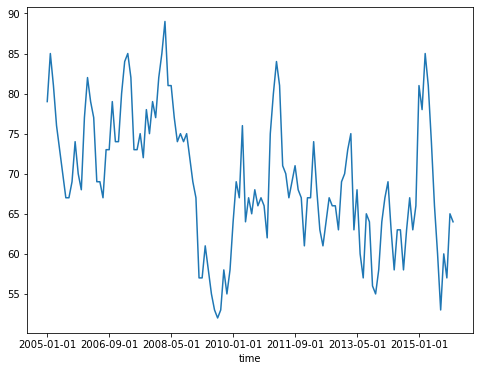

масштабирование данных и стандартизация

Результаты применения функции univariate_data

Single window of past history
[[ 1.04720801]
 [ 1.79879271]
 [ 1.29773624]
 [ 0.67141566]
 [ 0.29562331]
 [-0.08016903]
 [-0.45596138]
 [-0.45596138]
 [-0.20543315]
 [ 0.42088743]
 [-0.08016903]
 [-0.33069727]
 [ 0.79667978]
 [ 1.42300036]
 [ 1.04720801]]

 Target dif to predict
0.7966797776644878


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\envs\\tf\\lib\\site-packages\\matplotlib\\pyplot.py'>

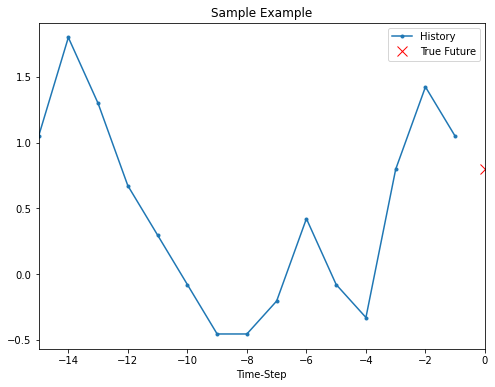

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
def baseline(history):
  return np.mean(history)

без привлечения машинного обучения

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\envs\\tf\\lib\\site-packages\\matplotlib\\pyplot.py'>

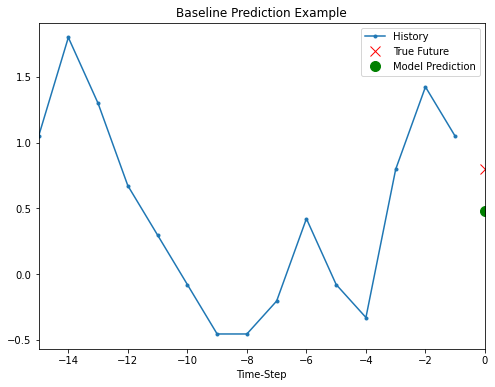

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Рекуррентная нейронная сеть

In [ ]:
print(train_univariate,train_univariate)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))> <RepeatDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

1/1 [==============================] - 0s 333ms/step
(10, 1)


In [ ]:
print(x_train_uni.shape)

(85, 15, 1)


У нас малый набора данных каждая эпоха будет проходить только 50 шагов (steps_per_epoch=50).

Epoch 1/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5992 - val_loss: 0.8267
Epoch 2/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5845 - val_loss: 0.8190
Epoch 3/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5915 - val_loss: 0.8076
Epoch 4/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5802 - val_loss: 0.7977
Epoch 5/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5825 - val_loss: 0.7873
Epoch 6/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5841 - val_loss: 0.7799
Epoch 7/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5691 - val_loss: 0.7757
Epoch 8/15
50/50 [==============================] - 0s 6ms/step - loss: 0.5717 - val_loss: 0.7710
Epoch 9/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5710 - val_loss: 0.7652
Epoch 10/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5714 - val_loss: 0.7583
Epoch 11/15
50/50 [

Прогнозирование с использованием простой модели LSTM

1/1 [==============================] - 0s 17ms/step


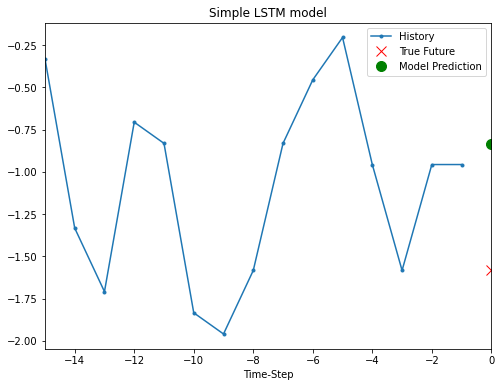

1/1 [==============================] - 0s 18ms/step


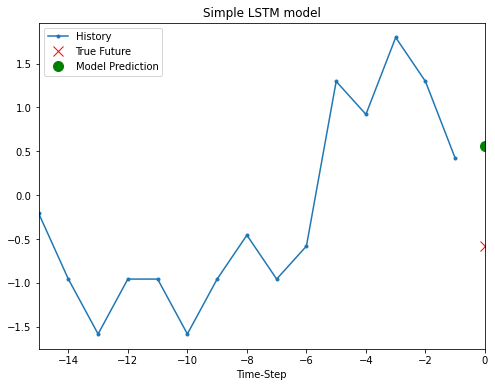

1/1 [==============================] - 0s 16ms/step


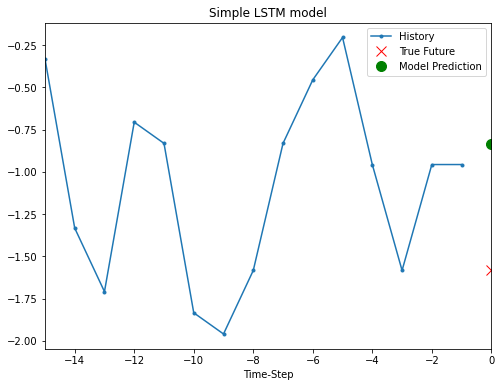

Прогнозирование на основе многомерного временного ряда

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index 
# + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
    

    if single_step:
      labels.append(target[i+target_size])
      
    else:
      labels.append(target[i:i+target_size])
    

  return np.array(data), np.array(labels)

def solution_multiclass(features, num_layers):
  features.index = df['time']
  features.head()
  dataset = features.values
  data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
  data_std = dataset[:TRAIN_SPLIT].std(axis=0)
  dataset = (dataset-data_mean) / data_std
  past_history = 100
  future_target = 3
  BATCH_SIZE = 10
  BUFFER_SIZE = 50
  EVALUATION_INTERVAL = 10
  EPOCHS = 20


  STEP = 1

  x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
  x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
  train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
  train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
  val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
  future_target = 8
  x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
  x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP) 
  single_step_model = tf.keras.models.Sequential()
  single_step_model.add(tf.keras.layers.LSTM(num_layers, input_shape=x_train_single.shape[-2:]))
  single_step_model.add(tf.keras.layers.Dense(1))

  single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
  single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1, verbose = 0)
  return single_step_model.evaluate(x_val_single, y_val_single)

from random import random, seed
for num_layers in range(1,10):
  seed(42)
  SAMPLE_NUM = 50
  sum = 0
  for i in range(0, SAMPLE_NUM):
    features_considered = [column for column in df.columns if column != 'time' and random() < 0.08]
    while (not len(features_considered)):
      features_considered = [column for column in df.columns if column != 'time' and random() < 0.08]
    sum += solution_multiclass(df[features_considered], num_layers)
  print(num_layers, sum / SAMPLE_NUM)


2/2 [==============================] - 0s 11ms/step - loss: 3.2666
1 2.749905607700348
2/2 [==============================] - 0s 12ms/step - loss: 3.1521
2 2.1894904237985613
2/2 [==============================] - 0s 10ms/step - loss: 3.1884
3 1.661748086810112
2/2 [==============================] - 0s 11ms/step - loss: 3.4064
4 1.717690637409687
2/2 [==============================] - 0s 10ms/step - loss: 0.8315


In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

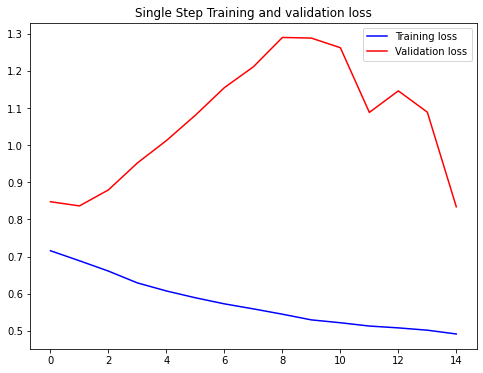

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

1/1 [==============================] - 0s 23ms/step


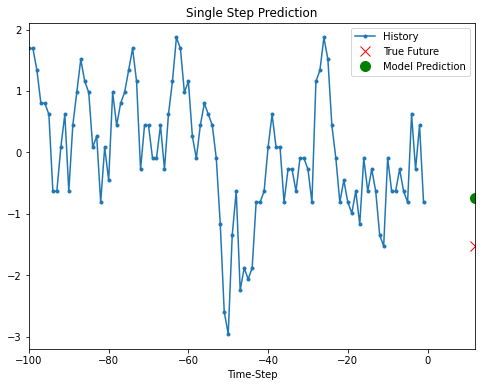

1/1 [==============================] - 0s 21ms/step


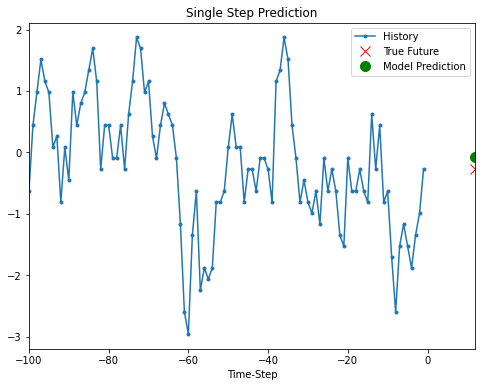

1/1 [==============================] - 0s 22ms/step


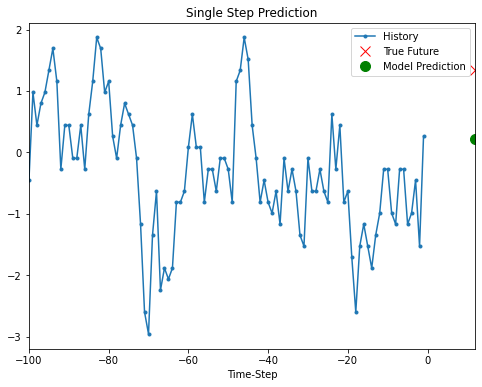

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target dif to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (100, 3)

 Target dif to predict : (8,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

Истинное будущее значение

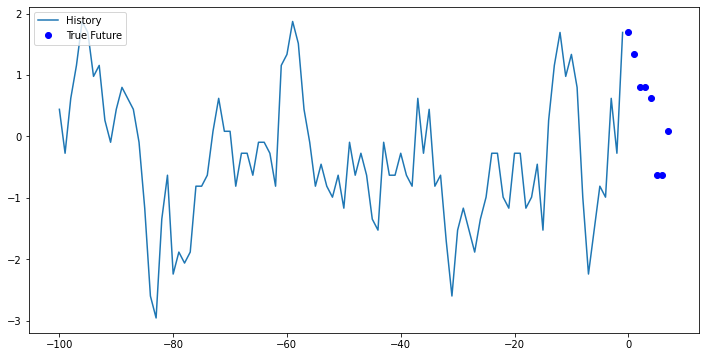

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(8,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(2, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(8))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

1/1 [==============================] - 0s 455ms/step
(10, 8)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=1)

Epoch 1/15
50/50 [==============================] - 5s 48ms/step - loss: 0.8069 - val_loss: 1.0588
Epoch 2/15
50/50 [==============================] - 2s 39ms/step - loss: 0.8033 - val_loss: 1.0441
Epoch 3/15
50/50 [==============================] - 2s 40ms/step - loss: 0.7963 - val_loss: 1.0311
Epoch 4/15
50/50 [==============================] - 2s 40ms/step - loss: 0.7867 - val_loss: 1.0139
Epoch 5/15
50/50 [==============================] - 2s 40ms/step - loss: 0.7743 - val_loss: 0.9966
Epoch 6/15
50/50 [==============================] - 2s 41ms/step - loss: 0.7578 - val_loss: 0.9714
Epoch 7/15
50/50 [==============================] - 2s 44ms/step - loss: 0.7439 - val_loss: 0.9582
Epoch 8/15
50/50 [==============================] - 2s 47ms/step - loss: 0.7321 - val_loss: 0.9389
Epoch 9/15
50/50 [==============================] - 2s 43ms/step - loss: 0.7206 - val_loss: 0.9237
Epoch 10/15
50/50 [==============================] - 2s 43ms/step - loss: 0.7108 - val_loss: 0.9183
Epoch 11/

Потери на этапах обучения и проверки модели

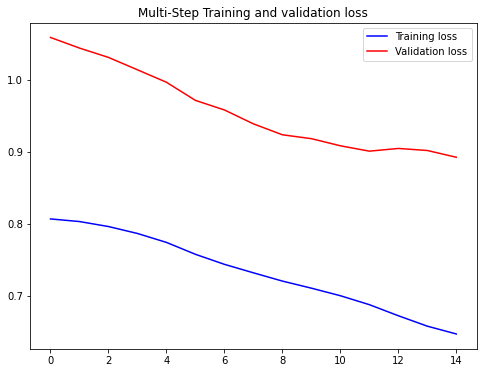

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

1/1 [==============================] - 0s 28ms/step


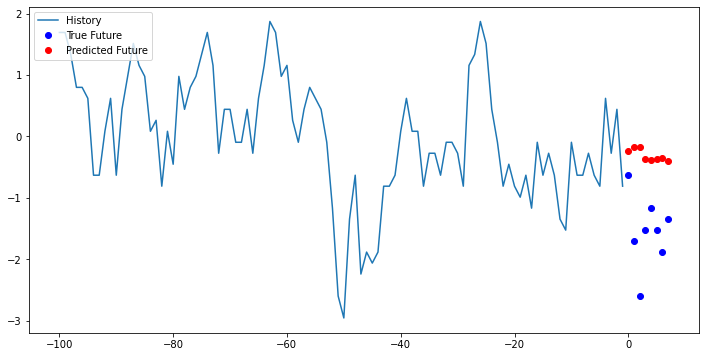

1/1 [==============================] - 0s 28ms/step


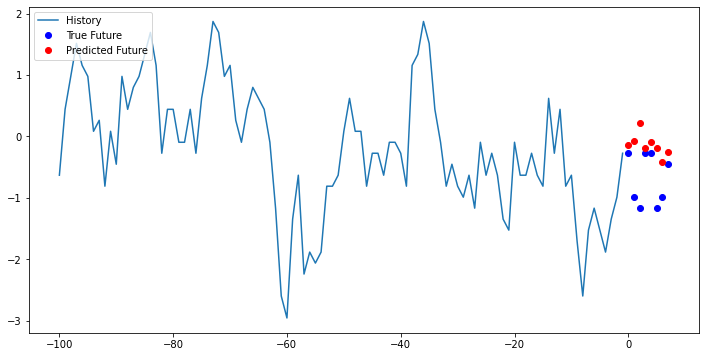

1/1 [==============================] - 0s 23ms/step


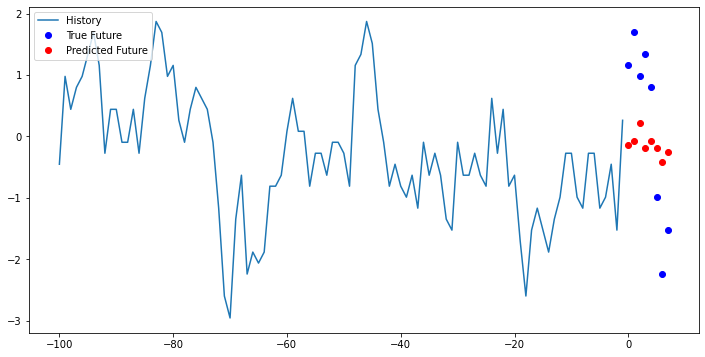

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])